## Question 1: Based on different health and lifestyle conditions, is it possible to predict is a person could have a heart attack?

Approach: Machine Learning model 

In [1]:
# Import all the libraries that will be used for processing and analysis
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import scipy.stats as st
from scipy.stats import ttest_ind
from scipy.stats import chi2_contingency
import pickle
import os

In [2]:
# the cleaned version of the data
data_cleaned = pd.read_csv('~/Desktop/data_analytics/Week_5/Mid_bootcamp_project/mid_bootcamp_project/data/cleaned/heart_data.csv', sep = ';')

In [3]:
# checking the relationship between the columns we will target, since bmi is numerical, we will do it separated

heart_attack_yes = data_cleaned[data_cleaned['had_heart_attack'] == 'Yes']['bmi']
heart_attack_no = data_cleaned[data_cleaned['had_heart_attack'] == 'No']['bmi']

t_statistic, p_value = ttest_ind(heart_attack_yes, heart_attack_no)
print(f"T-statistic: {t_statistic}")
print(f"P-value: {p_value}")

T-statistic: 9.874533884058689
P-value: 5.470986274140736e-23


Null hypothesis: No difference in BMI between who had a heart attack and who did not
Extremely low p-value 5.47e-23 which can be considered 0 suggests that we can reject this null hypothesis and there is a statistically significant difference in 'bmi' between those individuals

In [4]:
# selected columns for the model: we decided to select these health factors below to predict the heart attack chances
ml_model_data = ['had_heart_attack', 'had_angina', 'had_stroke', 'had_asthma', 'had_skin_cancer', 'had_copd', 'had_depressive_disorder','had_kidney_disease', 'had_arthritis', 'had_diabetes', 'covid_tested_positive']
ml_model = data_cleaned[ml_model_data].copy()
ml_model.head()

,had_heart_attack,had_angina,had_stroke,had_asthma,had_skin_cancer,had_copd,had_depressive_disorder,had_kidney_disease,had_arthritis,had_diabetes,covid_tested_positive
0,No,No,No,No,No,No,No,No,Yes,No,No
1,No,No,No,No,Yes,No,Yes,No,Yes,No,Yes
2,No,No,No,No,No,No,No,No,Yes,No,No
3,No,No,Yes,No,No,No,No,No,No,Yes,No
4,No,No,No,Yes,Yes,No,No,No,Yes,No,No


In [5]:
# checking the relationship between the columns we will target, all categorical nominal
def chi2_all_columns(df: pd.DataFrame, target_column: str) -> pd.DataFrame:
    '''
    Apply chi2 test between the column we will want to predict and all other columns in the dataframe

    Input: df.DataFrame and the target column
    Output: df.DataFrame with the chi2 and p-values
    '''

    chi2_results = pd.DataFrame(columns = ['column', 'chi2', 'p-value'])

    for column in df.columns:
        if column != target_column:
            contingency_table = pd.crosstab(df[target_column], df[column])
            chi2, p, _, _ = chi2_contingency(contingency_table)
            result = pd.DataFrame({'column': [column], 'chi2': [chi2], 'p-value': [p]})
            chi2_results = pd.concat([chi2_results, result], ignore_index = True)

    return chi2_results

In [6]:
results = chi2_all_columns(ml_model, 'had_heart_attack')
print(results)

                    column          chi2       p-value
0               had_angina  18765.286153  0.000000e+00
1               had_stroke   3640.497671  0.000000e+00
2               had_asthma    214.085874  1.763940e-48
3          had_skin_cancer     88.656548  4.696693e-21
4                 had_copd   2133.726649  0.000000e+00
5  had_depressive_disorder    138.742724  5.013713e-32
6       had_kidney_disease   1472.039372  0.000000e+00
7            had_arthritis   1586.481411  0.000000e+00
8             had_diabetes   2022.438058  0.000000e+00
9    covid_tested_positive     48.958573  2.614261e-12


/var/folders/4k/byg8gjqx3ld5757qnw63s0v00000gn/T/ipykernel_44364/216588939.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  chi2_results = pd.concat([chi2_results, result], ignore_index = True)


Here we come to the same conclusion we had above for BMI - these factors have an impact on having a heart attack or not

In [7]:
# we will not apply other transformations for the BMI skewness because below we will bin it, the skewness is below 2 
# and the extreme values are also possible and important for our analysis 
def hist_out_plot(df: pd.DataFrame, column: str) -> None:
    '''
    This function plots two types of graphs for the same column, in a way one can compare them: one can see
    the quartiles, means, and outliers due to their shared x-axis. 
    Input: pd.DataFrame
    Output: Boxplot and histogram for each column. 
    '''

    fig, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
    sns.boxplot(data=df, x=column, ax=ax_box)
    sns.histplot(data=df, x=column, ax=ax_hist)
    plt.show()

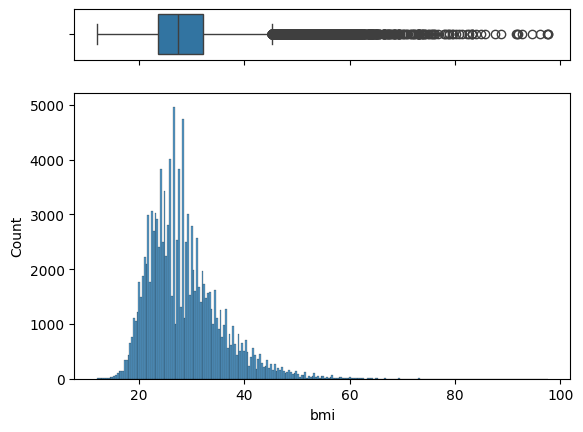

1.2811051329633496

In [8]:
hist_out_plot(data_cleaned, "bmi")
data_cleaned['bmi'].skew()

In [9]:
# binning the bmi values for the model since it is the only numerical column and it has an implied order
# between 0-18.5 -> underweight, between 18.5-25 -> healthy, above 25 -> overweight
# https://www.cdc.gov/healthyweight/assessing/bmi/adult_bmi/index.html

bmi_labels = ['1', '2', '3']
ml_model_bmi = pd.cut(data_cleaned['bmi'],[0,18.5,25,float('inf')], labels = bmi_labels)
ml_model_bmi.head()

0    3
1    3
2    3
3    3
4    2
Name: bmi, dtype: category
Categories (3, object): ['1' < '2' < '3']

In [10]:
# Transforming the "Yes" or "No" into 1 and 0
def change_binary(df: pd.DataFrame) -> pd.DataFrame:
    '''
    This function changes the column value to a numerical one based on the type of value.
    Input: the df: pd.DataFrame and the column to be changed in this df 
    Output: pd.DataFrame with the changed column. 
    '''
    for column in df.columns:
        df[column] = df[column].apply(lambda x: 1 if x == 'Yes' else 0)
    return df

In [11]:
change_binary(ml_model)
ml_model.head()

,had_heart_attack,had_angina,had_stroke,had_asthma,had_skin_cancer,had_copd,had_depressive_disorder,had_kidney_disease,had_arthritis,had_diabetes,covid_tested_positive
0,0,0,0,0,0,0,0,0,1,0,0
1,0,0,0,0,1,0,1,0,1,0,1
2,0,0,0,0,0,0,0,0,1,0,0
3,0,0,1,0,0,0,0,0,0,1,0
4,0,0,0,1,1,0,0,0,1,0,0


In [12]:
# preparing out dataframe for the machine learning process
ml_model = pd.concat([ml_model, ml_model_bmi], axis = 1)
ml_model.head()

,had_heart_attack,had_angina,had_stroke,had_asthma,had_skin_cancer,had_copd,had_depressive_disorder,had_kidney_disease,had_arthritis,had_diabetes,covid_tested_positive,bmi
0,0,0,0,0,0,0,0,0,1,0,0,3
1,0,0,0,0,1,0,1,0,1,0,1,3
2,0,0,0,0,0,0,0,0,1,0,0,3
3,0,0,1,0,0,0,0,0,0,1,0,3
4,0,0,0,1,1,0,0,0,1,0,0,2


In [13]:
# Split X/y
y = ml_model['had_heart_attack']
X = ml_model.drop(['had_heart_attack'], axis = 1)

In [14]:
# Defining the train and test sets 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 10)
X_train

,had_angina,had_stroke,had_asthma,had_skin_cancer,had_copd,had_depressive_disorder,had_kidney_disease,had_arthritis,had_diabetes,covid_tested_positive,bmi
93323,0,0,0,0,0,1,0,1,0,1,2
122926,0,0,1,0,0,0,0,0,0,0,3
31740,0,0,0,0,0,0,0,0,0,1,3
100438,0,0,0,0,0,0,0,0,0,0,3
120811,0,0,0,0,0,0,0,0,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...
93553,0,0,0,0,0,1,0,1,0,0,2
50496,0,0,0,0,0,1,0,1,0,0,3
94735,1,0,1,0,0,1,0,1,1,1,3
105597,0,0,1,0,0,0,0,0,0,0,3


In [15]:
# encoding to improve ML performance
encoder = OneHotEncoder(drop = 'first') 
encoder.fit(X_train)

path = "./Desktop/data_analytics/Week_5/Mid_bootcamp_project/mid_bootcamp_project/encoders/"
os.makedirs(path, exist_ok = True)
filename = "one_hot_encoder.pkl"
with open(os.path.join(path, filename), "wb") as file:
    pickle.dump(encoder, file)

X_train_np = encoder.transform(X_train).toarray()
X_test_np  = encoder.transform(X_test).toarray()

X_train_encoded_df = pd.DataFrame(X_train_np, columns = encoder.get_feature_names_out(), index = X_train.index)
X_test_encoded_df = pd.DataFrame(X_test_np,  columns = encoder.get_feature_names_out(), index = X_test.index)

X_train_encoded_df.head()

,had_angina_1,had_stroke_1,had_asthma_1,had_skin_cancer_1,had_copd_1,had_depressive_disorder_1,had_kidney_disease_1,had_arthritis_1,had_diabetes_1,covid_tested_positive_1,bmi_2,bmi_3
93323,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0
122926,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
31740,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
100438,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
120811,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [16]:
# applying model
lr = LogisticRegression(random_state = 69)
lr.fit(X_train_encoded_df, y_train)

path = "./Desktop/data_analytics/Week_5/Mid_bootcamp_project/mid_bootcamp_project/models/"
os.makedirs(path, exist_ok = True)
filename = "lr.pkl"
with open(os.path.join(path, filename), "wb") as file:
    pickle.dump(lr, file)

y_train_pred = lr.predict(X_train_encoded_df)
y_test_pred_base = lr.predict(X_test_encoded_df)

In [17]:
# model results
def metrics_report(y_test: list, y_test_pred: list) -> pd.DataFrame:
    '''
    Function: Calculate the various metrics for a given set of test data prediction and 
    organises them into a dataframe for easier visualisation
    Inputs: y_test and y_test_pred
    Outputs: Dataframe with metrics column for the test set 
    '''
    
    accuracy_test = accuracy_score(y_test,y_test_pred)
    precision_test = precision_score(y_test,y_test_pred)
    recall_test = recall_score(y_test,y_test_pred)
    F1_test = f1_score(y_test,y_test_pred)
    Kappa_test = cohen_kappa_score(y_test,y_test_pred)
    

    results = {"Metric": ['accuracy', 'precision', 'recall', 'F1', 'Kappa'], 
               "Test":  [accuracy_test, precision_test, recall_test, F1_test, Kappa_test]}

    results_df = pd.DataFrame(results)

    return results_df

Metrics explained: 
    
Accuracy:

Formula: (True Positives + True Negatives) / Total Predictions
Interpretation: Accuracy measures the overall correctness of the model across all classes. It's the ratio of correctly predicted instances to the total instances.
    
2. Precision:

Formula: True Positives / (True Positives + False Positives)
Interpretation: Precision is the ability of the model not to label a positive sample as negative. It focuses on the accuracy of positive predictions.
    
3. Recall (Sensitivity or True Positive Rate):

Formula: True Positives / (True Positives + False Negatives)
Interpretation: Recall is the ability of the model to capture all the positive instances. It focuses on minimizing false negatives.
    
4. F1 Score:

Formula: 2 * (Precision * Recall) / (Precision + Recall)
Interpretation: The F1 score is the harmonic mean of precision and recall. It provides a balance between precision and recall, useful when there is an uneven class distribution.
    
5. Kappa (Cohen's Kappa):

Formula: (Observed Accuracy - Expected Accuracy) / (1 - Expected Accuracy)
Interpretation: Kappa measures the agreement between the actual and predicted classifications while accounting for the possibility of chance agreement. It's particularly useful when dealing with imbalanced classes.

Note:
True Positives (TP): Instances correctly predicted as positive.
True Negatives (TN): Instances correctly predicted as negative.
False Positives (FP): Instances incorrectly predicted as positive.
False Negatives (FN): Instances incorrectly predicted as negative.

In [18]:
metrics_report(y_test, y_test_pred_base)

,Metric,Test
0,accuracy,0.961272
1,precision,0.469466
2,recall,0.126283
3,F1,0.199029
4,Kappa,0.185878


In [19]:
metrics_report(y_train, y_train_pred)

,Metric,Test
0,accuracy,0.961339
1,precision,0.502361
2,recall,0.134411
3,F1,0.212079
4,Kappa,0.198989


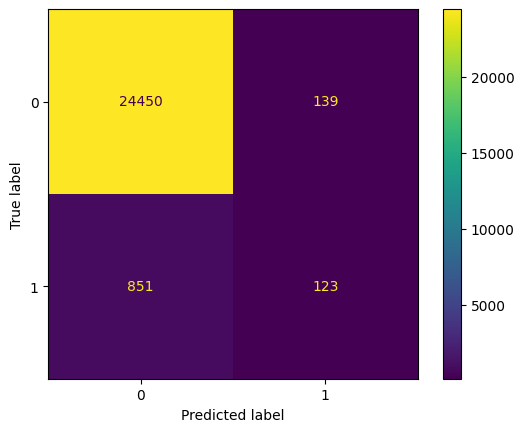

In [20]:
# Matrix of the results 
cm_test = confusion_matrix(y_test,y_test_pred_base)
disp = ConfusionMatrixDisplay(confusion_matrix = cm_test, display_labels = lr.classes_)
disp.plot()
plt.show()

In [21]:
# the discussion will follow below

had_heart_attack
0    122879
1      4932
Name: count, dtype: int64


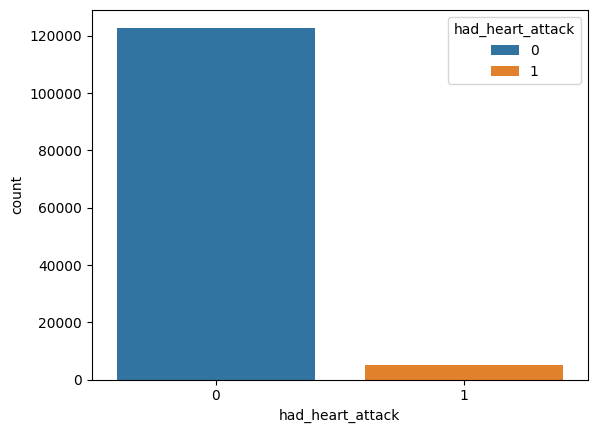

In [22]:
# looking at the metrics above, specially the Kappa, we know there is a huge class imbalance
count_classes = ml_model['had_heart_attack'].value_counts()
print(count_classes)
sns.countplot(x = 'had_heart_attack', data = ml_model, hue = 'had_heart_attack')
plt.show()

In [23]:
# let's try to improve the results reducing the class imbalance 
# ONLY in the TRAIN samples

In [24]:
from imblearn.over_sampling import RandomOverSampler 

ros = RandomOverSampler(random_state = 42)

X_train_over, y_train_over = ros.fit_resample(X_train_encoded_df, y_train)

print(y_train_over.value_counts())

lr_1 = LogisticRegression()
lr_1.fit(X_train_over, y_train_over)

path = "./Desktop/data_analytics/Week_5/Mid_bootcamp_project/mid_bootcamp_project/models/"
os.makedirs(path, exist_ok = True)
filename = "lr_ran_over_sampler.pkl"
with open(os.path.join(path, filename), "wb") as file:
    pickle.dump(lr_1, file)
    
y_test_pred_over = lr_1.predict(X_test_encoded_df)

had_heart_attack
0    98290
1    98290
Name: count, dtype: int64


In [25]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state = 42)

X_train_under, y_train_under = rus.fit_resample(X_train_encoded_df, y_train)

print(y_train_under.value_counts())

lr_2 = LogisticRegression()
lr_2.fit(X_train_under, y_train_under)

path = "./Desktop/data_analytics/Week_5/Mid_bootcamp_project/mid_bootcamp_project/models/"
os.makedirs(path, exist_ok = True)
filename = "lr_ran_under_sampler.pkl"
with open(os.path.join(path, filename), "wb") as file:
    pickle.dump(lr_2, file)
    
y_test_pred_under = lr_2.predict(X_test_encoded_df)

had_heart_attack
0    3958
1    3958
Name: count, dtype: int64


In [26]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state = 100) # k_neighbors default is 5 (we also tried with different numbers, this gave the best outcome)

X_train_SMOTE,y_train_SMOTE = sm.fit_resample(X_train_encoded_df, y_train)

print(y_train_SMOTE.value_counts())

lr_3 = LogisticRegression()
lr_3.fit(X_train_SMOTE, y_train_SMOTE)

path = "./Desktop/data_analytics/Week_5/Mid_bootcamp_project/mid_bootcamp_project/models/"
os.makedirs(path, exist_ok = True)
filename = "lr_SMOTE_sampler.pkl"
with open(os.path.join(path, filename), "wb") as file:
    pickle.dump(lr_3, file)
    
y_test_pred_SMOTE = lr_3.predict(X_test_encoded_df)

had_heart_attack
0    98290
1    98290
Name: count, dtype: int64


In [27]:
from imblearn.under_sampling import TomekLinks

tl = TomekLinks()

X_train_tl, y_train_tl = tl.fit_resample(X_train_encoded_df, y_train)

print(y_train_tl.value_counts())

lr_4 = LogisticRegression()
lr_4.fit(X_train_tl, y_train_tl)

path = "./Desktop/data_analytics/Week_5/Mid_bootcamp_project/mid_bootcamp_project/models/"
os.makedirs(path, exist_ok = True)
filename = "lr_tomeklinks.pkl"
with open(os.path.join(path, filename), "wb") as file:
    pickle.dump(lr_4, file)
    
y_test_pred_tl = lr_4.predict(X_test_encoded_df)

had_heart_attack
0    98287
1     3958
Name: count, dtype: int64


In [28]:
display("Metrics report for the logistics regression:")
display(metrics_report(y_test, y_test_pred_base))

display("Metrics report for the RandomOverSampler logistics regression:")
display(metrics_report(y_test, y_test_pred_over))

display("Metrics report for the RandomUnderSampler logistics regression:")
display(metrics_report(y_test, y_test_pred_under))

display("Metrics report for the SMOTE logistics regression:")
display(metrics_report(y_test, y_test_pred_SMOTE))

display("Metrics report for the TomekLinks logistics regression:")
display(metrics_report(y_test, y_test_pred_tl))

'Metrics report for the logistics regression:'

,Metric,Test
0,accuracy,0.961272
1,precision,0.469466
2,recall,0.126283
3,F1,0.199029
4,Kappa,0.185878


'Metrics report for the RandomOverSampler logistics regression:'

,Metric,Test
0,accuracy,0.844971
1,precision,0.154611
2,recall,0.686858
3,F1,0.252405
4,Kappa,0.202819


'Metrics report for the RandomUnderSampler logistics regression:'

,Metric,Test
0,accuracy,0.846614
1,precision,0.156286
2,recall,0.687885
3,F1,0.254704
4,Kappa,0.205361


'Metrics report for the SMOTE logistics regression:'

,Metric,Test
0,accuracy,0.843406
1,precision,0.153512
2,recall,0.688912
3,F1,0.251076
4,Kappa,0.201303


'Metrics report for the TomekLinks logistics regression:'

,Metric,Test
0,accuracy,0.961233
1,precision,0.468165
2,recall,0.128337
3,F1,0.201450
4,Kappa,0.188140


In [29]:
under = [y_test, y_test_pred_under]
over = [y_test, y_test_pred_over]
SMOTE = [y_test, y_test_pred_SMOTE]
tl = [y_test, y_test_pred_tl]

to_plot = [under, over, SMOTE, tl]

In [30]:
def cm_matrix(y_test_list) -> None:
    '''
    This function creates confusion matrix for all the y_test and their predictions given in a list.
    Input: List
    Output: Confusion Matrix for each element of the list. 
    '''
      
    for element in y_test_list:
        cm_test = confusion_matrix(element[0], element[1])
        disp = ConfusionMatrixDisplay(confusion_matrix = cm_test, display_labels = lr.classes_)
        disp.plot()
        plt.show()

## "No": less chances of having a heart attack -> 0 and "Yes": higher chances of having a heart attack -> 1

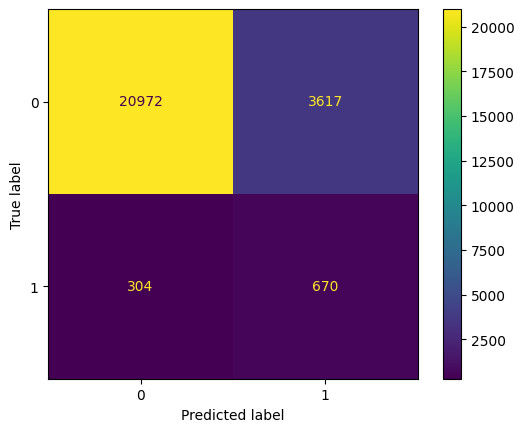

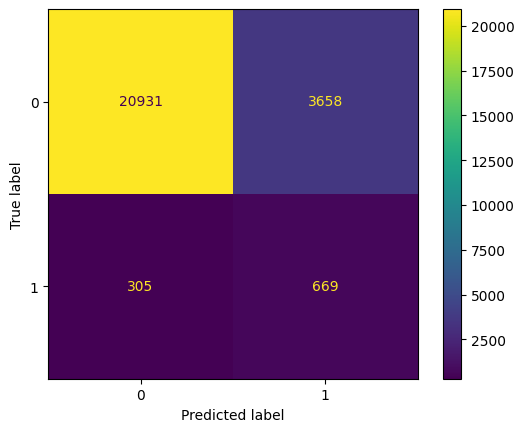

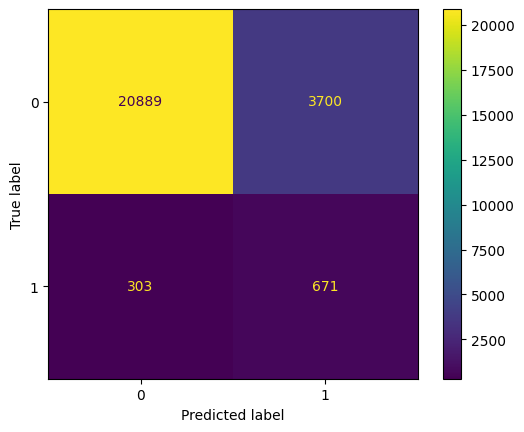

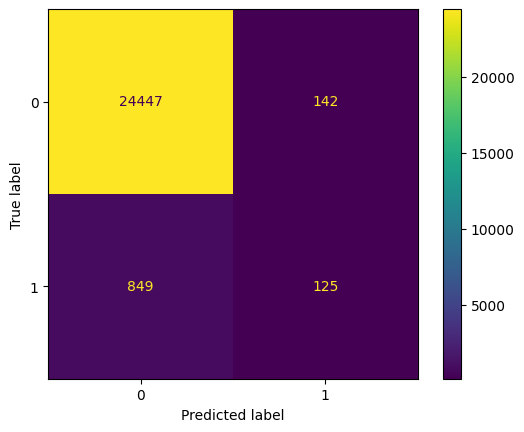

In [31]:
cm_matrix(to_plot)

In [32]:
values = list(zip(list(X_test.columns), list(np.abs(lr.coef_).round(2)[0])))

coef_best_pred = pd.DataFrame(values, columns = ['Condition', 'Coeficient']).sort_values(by = 'Coeficient', ascending = False)
coef_best_pred.reset_index(drop = True)

,Condition,Coeficient
0,had_angina,2.68
1,had_stroke,1.18
2,had_diabetes,0.66
3,had_copd,0.58
4,had_arthritis,0.53
5,bmi,0.41
6,had_kidney_disease,0.40
7,covid_tested_positive,0.13
8,had_skin_cancer,0.05
9,had_depressive_disorder,0.05


# Conclusion: 

Looking at the table above, it tells us which of the features have the highest impact on determining in a person will or will not have a heart attack, with angina being the one which has more impact, followed by stroke.

https://www.nhlbi.nih.gov/health/angina#:~:text=Angina%2C%20also%20known%20as%20angina,become%20partially%20or%20totally%20blocked.

-> Accuracy: the highest accuracy was in the logistic regression with no dealing with the class imbalance, which makes sense since we have class imbalance with a lot more "No" values than "Yes", the chances of predicting a correct "No" will be higher

-> Precision: same as above  

-> Recall: quite important here since it is about reducing false negatives, the best here would be using SMOTE with 0.69

-> F1 Score: here the Random Under Sampler had the highest F1 Score, besides the normal logistic regression and the tomeklinks, the rest of the ways of dealing with class imbalance, had an impact on this value, since this value is sensitive to class unbalance

-> Kappa: here as well the Random Under Sampler had the highest Kappa, due to the same reasons above


false negatives // method

851 normal logistic regression

304 random under sampler

305 random over sampler

301 SMOTE

849 tomeklinks


SMOTE is the best method here, since it reduces the amount of false negatives and in the context of this research, it is the most important goal, even if it will cost false positive results



## Question 2: Are women that use e-cigarette more prone to suffer from heart attack than those who don’t use it?

Approach: Probability, hypothesis

In [33]:
ecig_heart = pd.crosstab(data_cleaned['e_cigarette_usage'], data_cleaned['had_heart_attack'])
ecig_heart

had_heart_attack,No,Yes
e_cigarette_usage,,
Current user,5644,169
Former user,19535,850
Never used,97700,3913


In [34]:
st.chi2_contingency(ecig_heart)

Chi2ContingencyResult(statistic=19.51590044027289, pvalue=5.783304573518702e-05, dof=2, expected_freq=array([[ 5588.68663104,   224.31336896],
       [19598.37897364,   786.62102636],
       [97691.93439532,  3921.06560468]]))

# Conclusion: 

Ho: there are no relationship/differences
    
Ha: there are relationship/differences

p_value < alpha -> Reject H0 // alpha = 0.05

the results suggest that ecig and heart attack are related